# Visualisation

In [10]:
import pandas as pd

df = pd.read_csv('../data/tx_statewide_2020_04_01-002_clean.csv')
df

,location,lat,lng,county_name,subject_race,subject_sex,search_conducted,search_vehicle,vehicle_year,timestamp
0,"route: 0010, milepost: 637",29.650999,-97.519203,Gonzales County,4,1,0.0,0.0,0,2008-08-12 13:46:00
1,"route: 0010, milepost: 637",29.650600,-97.506065,Gonzales County,4,1,0.0,0.0,0,2008-08-12 13:46:00
2,"route: 0271, milepost: 198",33.733150,-95.547417,Lamar County,0,1,0.0,0.0,0,2008-08-12 13:46:00
3,"route: 0010, milepost: 795",NaN,NaN,Harris County,0,0,0.0,0.0,0,2008-08-12 13:46:00
4,"route: 0303, milepost: 228",33.460667,-102.489120,Hockley County,4,1,0.0,0.0,0,2008-08-12 13:47:00
...,...,...,...,...,...,...,...,...,...,...
19752781,"route: 0016, milepost: 626",29.061701,-98.591515,Atascosa County,0,1,0.0,0.0,2003,2013-12-29 13:04:00
19752782,milepost: 0,26.102793,-97.629265,Cameron County,2,0,0.0,0.0,1999,2013-12-29 13:04:00
19752783,"route: 0020, milepost: 315",31.949709,-102.163567,Midland County,2,1,0.0,0.0,2007,2013-12-29 13:04:00
19752784,"route: 0035, milepost: 360",31.950699,-97.112381,Hill County,0,1,0.0,0.0,2004,2013-12-29 13:04:00


<!-- from pyspark.sql.functions import col, count, when, isnan, isnull
from pyspark.sql.functions import col, when

# make subject_sex 1 if 'male' and 0 if 'female'
df = df.withColumn("subject_sex", when(col("subject_sex") == "male", 1).otherwise(0).cast("integer"))

# make lat and long float
df = df.withColumn("lat", col("lat").cast("float"))
df = df.withColumn("lng", col("lng").cast("float"))

# make subject_race 0 if 'white', 1 if 'black', 2 if 'hispanic', 3 if 'asian', 4 if 'other' and make it an integer column
df = df.withColumn("subject_race", when(col("subject_race") == "white", 0)
                                   .when(col("subject_race") == "black", 1)
                                   .when(col("subject_race") == "hispanic", 2)
                                   .when(col("subject_race") == "asian", 3)
                                   .otherwise(4).cast("integer"))


# make search_vehicle 1 if TRUE and 0 if FALSE else NA
df = df.withColumn("search_vehicle", when(col("search_vehicle") == "TRUE", 1)
                                    .when(col("search_vehicle") == "FALSE", 0)
                                    .otherwise(None).cast("integer"))

# make vehicle_year an integer column and fill NA with 0
df = df.withColumn("vehicle_year", col("vehicle_year").cast("integer"))
df = df.withColumn("vehicle_year", when(col("vehicle_year").isNull(), 0).otherwise(col("vehicle_year")))
df = df.withColumn("vehicle_year", when(col("vehicle_year") < 1900, 0).otherwise(col("vehicle_year")))
df = df.withColumn("vehicle_year", when(col("vehicle_year") > 2022, 0).otherwise(col("vehicle_year")))

# date column is of format 'yyyy-mm-dd' and time column is of format 'hh:mm:ss': combine them into a single timestamp column
from pyspark.sql.functions import to_timestamp, concat_ws

df = df.withColumn("timestamp", to_timestamp(concat_ws(" ", col("date"), col("time")), "yyyy-MM-dd HH:mm:ss"))

# drop date and time columns
df = df.drop("date", "time")

# make search_conducted 1 if TRUE or citation and 0 if FALSE else NA and make it an integer column
from pyspark.sql.functions import col, when, to_timestamp, concat_ws

df = df.withColumn("search_conducted", when((col("search_conducted") == "TRUE") | (col("search_conducted") == "citation"), 1)
                                      .when(col("search_conducted") == "FALSE", 0)
                                      .otherwise(None).cast("integer")) -->

cleaning done in pyspark

In [11]:
subject_sex = {1: 'male', 0: 'female'}
subject_race = {1: 'white', 2: 'black', 3: 'hispanic', 4: 'asian', 5: 'other'}

[Macro](#Macro)
- Median number of tickets per day.
- Plot the number of tickets per hour of the day/Does time of day affect crime.
- Plot the distribution of tickets by county or location.
- Plot the yearly evolution of the number of tickets.
- Investigate if there's a correlation between the number of tickets and specific events or holidays.

[Disparity](#Disparity)
- Gender distribution of tickets. (take into account the proportion of population)
- Plot the correlation between men and women getting a ticket for speeding.
- Explore if certain vehicle types or colors are more likely to get a ticket.
- How predictable are the stop rates, is there a time and place where you are more likely to get a ticket ?
- Address the concern about jurisdictions using civil forfeiture as a funding mechanism rather than to properly fight drug trafficking.
- Race disparity

NUMBER OF MALE AND FEMALE

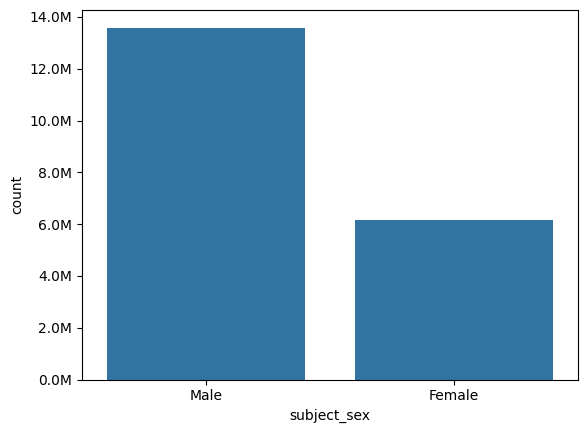

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker

# Assuming df is your DataFrame and it's already loaded with data

# Map 0 to Female and 1 to Male in the subject_sex column
df['subject_sex'] = df['subject_sex'].map({0: 'Female', 1: 'Male'})

# Plot with the updated DataFrame
ax = sns.countplot(x='subject_sex', data=df)

# Format y-axis ticks in millions if applicable (for demonstration)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 1e-6}M'))

plt.show()

NUMBER OF TICKES PER DAYS

In [13]:
# tickets_per_day = df.groupby(df['timestamp'].dt.date).size()

# median_tickets_per_day = tickets_per_day.median()

# print("Median number of tickets per day:", median_tickets_per_day)

# # Plot
# plt.figure(figsize=(20, 6))
# tickets_per_day.plot()
# plt.title('Number of Tickets per Day')
# plt.xlabel('Year')
# plt.ylabel('Number of Tickets')
# plt.show()

NUMBER OF TICKETS BY COUNTY

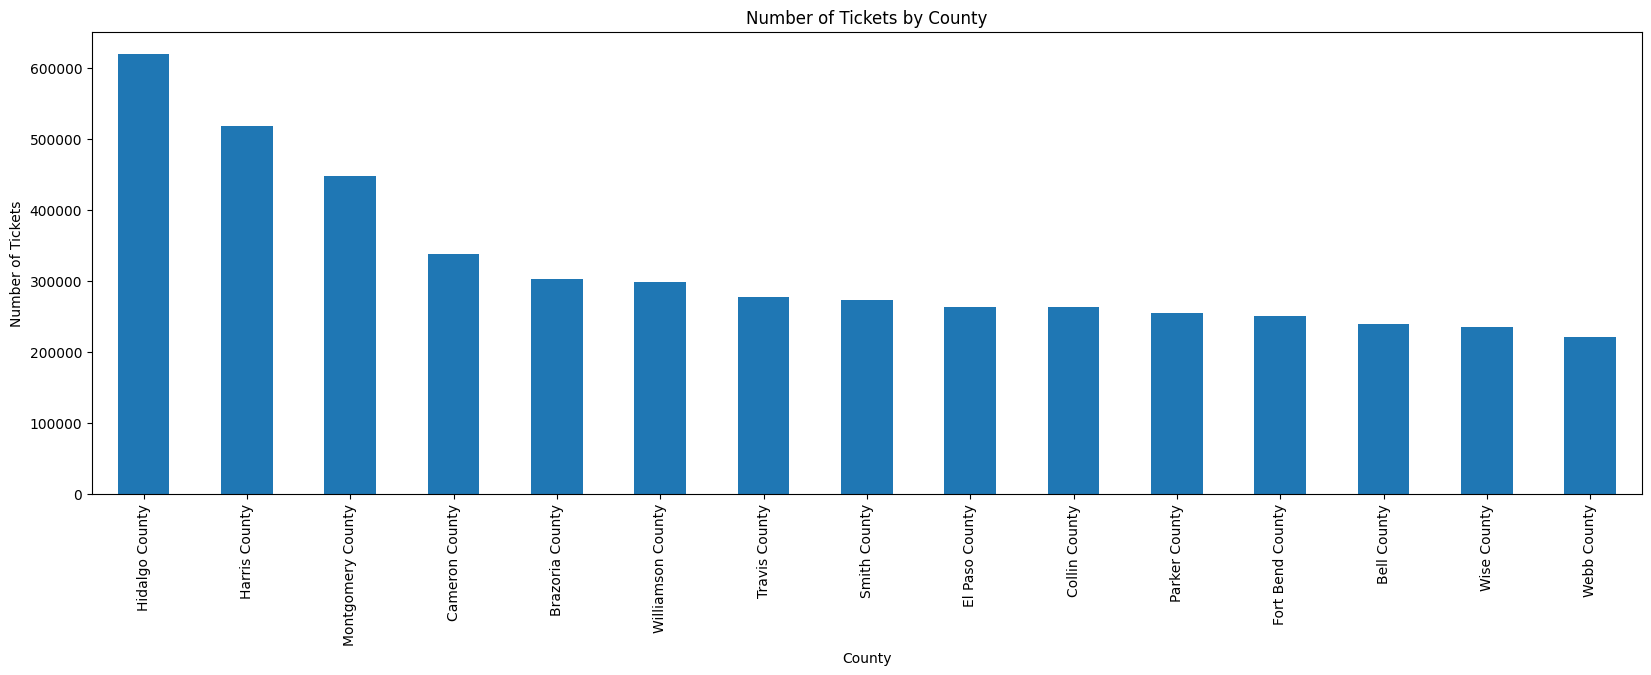

In [14]:
# Show the number of tickets by county just the 10 counties with the most tickets
top_10_counties = df['county_name'].value_counts().head(15)

# Plot
plt.figure(figsize=(20, 6))
top_10_counties.plot(kind='bar')
plt.title('Number of Tickets by County')
plt.xlabel('County')
plt.ylabel('Number of Tickets')
plt.show()

NUMBER OF TICKETS PER DAYS

In [15]:
# Plot the yearly evolution of the number of tickets.
tickets_per_year = df.groupby(df['timestamp'].dt.year).size()

# Plot
plt.figure(figsize=(10, 6))
tickets_per_year.plot(kind='bar')
plt.title('Number of Tickets per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tickets')
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

NUMBER OF TICKETS PER MONTH

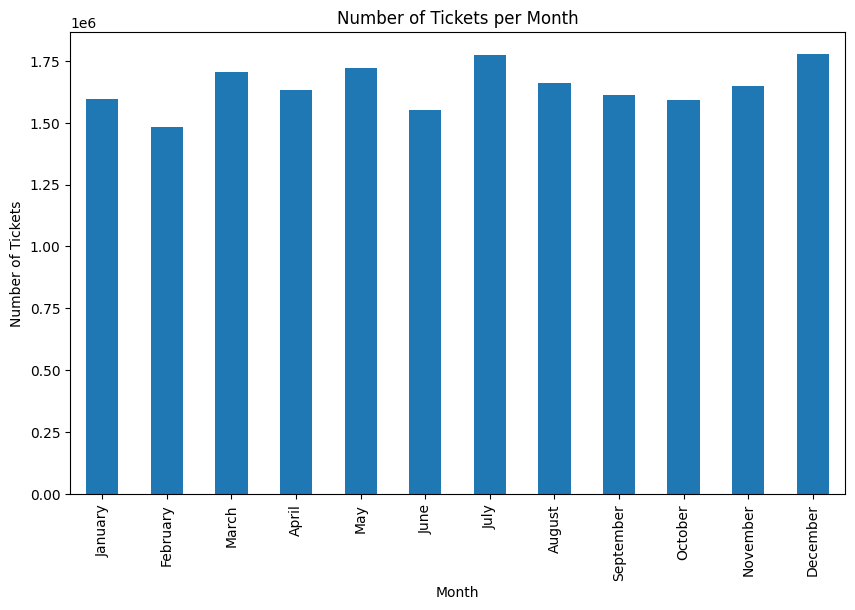

In [ ]:
# Investigate if there's a correlation between the number of tickets and specific events or holidays.
# For example, plot the number of tickets by month.
tickets_per_month = df.groupby(df['timestamp'].dt.month).size()

# Map month numbers to month names
month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Rename the index of tickets_per_month using the month_names dictionary
tickets_per_month.index = tickets_per_month.index.map(month_names)

# Plot
plt.figure(figsize=(10, 6))
tickets_per_month.plot(kind='bar')
plt.title('Number of Tickets per Month')
plt.xlabel('Month')
plt.ylabel('Number of Tickets')
plt.show()


GENDER DISTRIBUTION OF TICKETS

C:\Users\Theo Boucebaine\AppData\Local\Temp\ipykernel_8852\1552325556.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='subject_sex', data=df, palette='pastel', order=df['subject_sex'].value_counts().index)


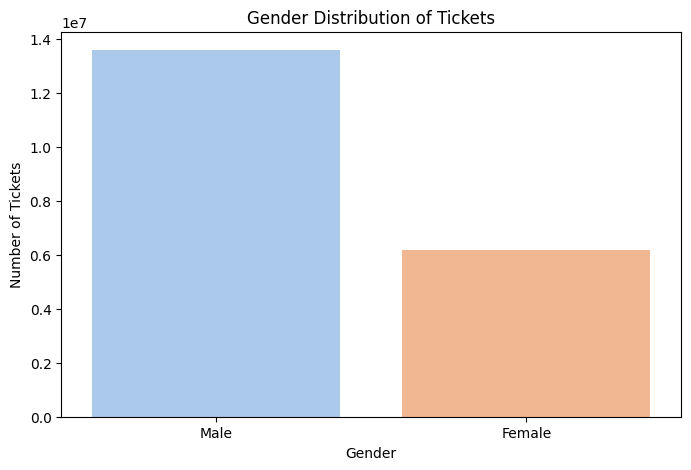

In [ ]:
# Gender distribution of tickets. (take into account the proportion of population)
# Plot
plt.figure(figsize=(8, 5))
sns.countplot(x='subject_sex', data=df, palette='pastel', order=df['subject_sex'].value_counts().index)
plt.title('Gender Distribution of Tickets')
plt.xlabel('Gender')
plt.ylabel('Number of Tickets')
plt.show()

In [ ]:
# Plot the correlation between men and women getting a ticket for speeding.

speeding_tickets = df[df['violation'] == 'speeding']#

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(x='subject_sex', data=speeding_tickets, palette='pastel', order=speeding_tickets['subject'].value_counts().index)
plt.title('speeding Tickets')
plt.xlabel('Gender')
plt.ylabel('Number of Tickets')
plt.show()

KeyError: 'violation'

Yearly evolution of the number of tickets.

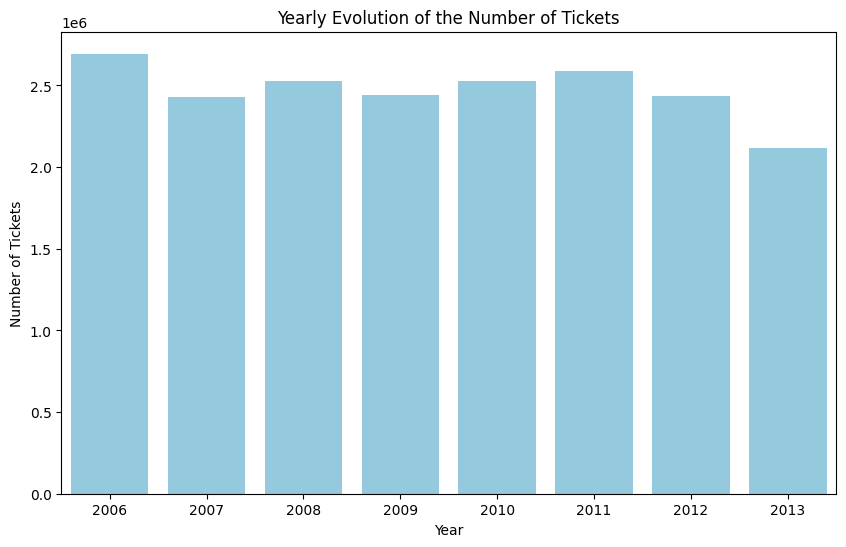

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['year'] = df['timestamp'].dt.year

tickets_per_year = df.groupby('year').size()

# Plot avec Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=tickets_per_year.index, y=tickets_per_year, color='skyblue')
plt.title('Yearly Evolution of the Number of Tickets')
plt.xlabel('Year')
plt.ylabel('Number of Tickets')
plt.show()

C:\Users\Theo Boucebaine\AppData\Local\Temp\ipykernel_10324\588989299.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,}'.format(int(x/1_000_000)) for x in ax.get_yticks()])


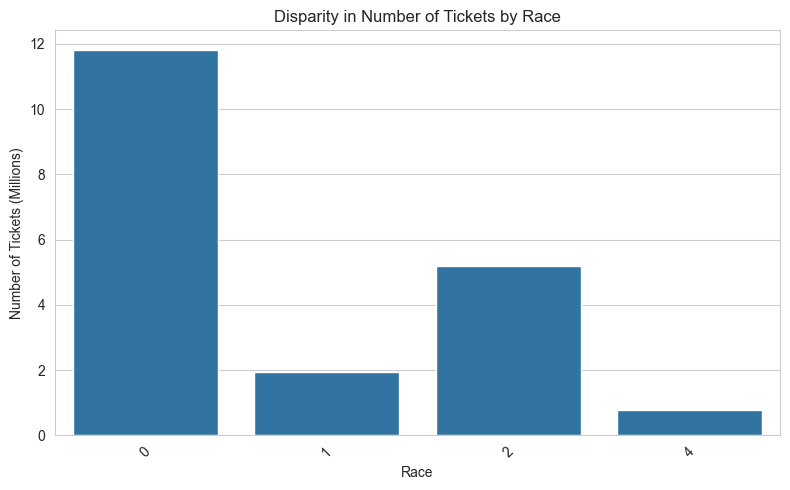

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
sns.set_style("whitegrid")

# Plot the countplot
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='subject_race')

# Convert y-axis labels to millions
ax.set_yticklabels(['{:,}'.format(int(x/1_000_000)) for x in ax.get_yticks()])

plt.title('Disparity in Number of Tickets by Race')
plt.xlabel('Race')
plt.ylabel('Number of Tickets (Millions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# 0 = white, 1 = black, 2 = hispanic, 3 = asian, 4 = other

In [17]:
df["subject_race"].value_counts()

subject_race
0    11819820
2     5198354
1     1946888
4      787724
Name: count, dtype: int64